<IMG align="left" src="https://www.pinclipart.com/picdir/big/499-4991215_css-logo-png-css-corp-company-logo-clipart.png" width="100"/>

                      
                               _   _   _    __   _  _    __    _       __    __    _____  
                              | \ / | | | /' _/ | || |  /  \  | |     |  \  /__\  |_   _|
                              `\ V /' | | `._`. | \/ | | /\ | | |_    | -< | \/ |   | |
                                \_/   |_| |___/  \__/  |_||_| |___|   |__/  \__/    |_|
                      

# Import libraries

In [ ]:
import pandas as pd
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Import dataset

In [1]:
data=pd.read_csv("./datalabel.csv")

In [2]:
data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,backpanel_0.jpg,800,600,Switch button,214,295,258,341
1,backpanel_0.jpg,800,600,Power port,264,296,300,336
2,backpanel_0.jpg,800,600,Ethernet port,314,295,374,335
3,backpanel_1.jpg,800,600,Switch button,219,304,253,341
4,backpanel_1.jpg,800,600,Power port,258,306,293,339


# Visualize dataset

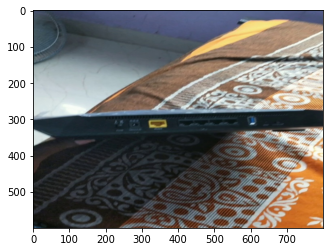

In [16]:
img0=np.array(Image.open('./images/backpanel_0.jpg'))
plt.imshow(img0)
plt.show()

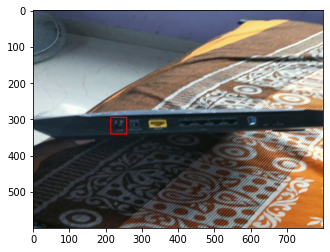

In [18]:
cv2.rectangle(img0, (data.loc[0,"xmin"],data.loc[0,"ymin"]), (data.loc[0,"xmax"], data.loc[0,"ymax"]), (255, 0, 0), 2) 
plt.imshow(img0)
plt.show()

# Bounding box transformation for YOLO

In [26]:
label_str='0'

In [23]:
def convert_coordinates(size, box):
    dw = 1.0/size[0]
    dh = 1.0/size[1]
    x = (box[0]+box[1])/2.0
    y = (box[2]+box[3])/2.0
    w = box[1]-box[0]
    h = box[3]-box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [24]:
width=img0.shape[1]
height=img0.shape[0]
b = (float(data.loc[0,"xmin"]), float(data.loc[0,"xmax"]), float(data.loc[0,"ymin"]), float(data.loc[0,"ymax"]))
bb = convert_coordinates((width,height), b)

In [27]:
label_str + " " + " ".join([("%.6f" % a) for a in bb])

'0 0.295000 0.530000 0.055000 0.076667'

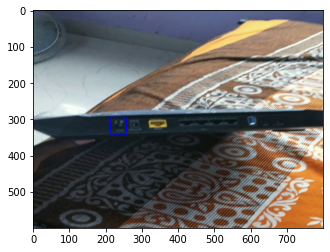

In [30]:
# get contours
result = img0.copy()
normalized_coordinates=[0.295000, 0.530000, 0.055000, 0.076667]
x1, y1, w_size, h_size=normalized_coordinates[0], normalized_coordinates[1], normalized_coordinates[2],normalized_coordinates[3]
x_start = round((x1 - (w_size/2))*img0.shape[1])
y_start = round((y1 - (h_size/2))*img0.shape[0])
x_end = round((x_start + w_size*img0.shape[1]))
y_end = round((y_start + h_size*img0.shape[0]))
cv2.rectangle(result, (x_start, y_start), (x_end, y_end), (0, 0, 255), 2) 
plt.imshow(result)
plt.show()

#  Exploratory data analysis

In [33]:
data["class"].value_counts()

Router            1636
Ethernet cable    1551
Ethernet port     1230
Switch button      879
Power port         811
Power cable        631
Green              567
Red                513
Name: class, dtype: int64

# Generate YOLO format

In [1]:
import os
path="./YOLOdata/"
if not os.path.exists(path):os.makedirs(path)
import pandas as pd
data=pd.read_csv("datalabel.csv")
lut=dict(zip(list(set(data["class"].values)),[i for i in range(0,len(set(data["class"].values)))]))
lut

{'Red': 0,
 'Router': 1,
 'Ethernet cable': 2,
 'Power port': 3,
 'Power cable': 4,
 'Ethernet port': 5,
 'Switch button': 6,
 'Green': 7}

In [3]:
data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,backpanel_0.jpg,800,600,Switch button,214,295,258,341
1,backpanel_0.jpg,800,600,Power port,264,296,300,336
2,backpanel_0.jpg,800,600,Ethernet port,314,295,374,335
3,backpanel_1.jpg,800,600,Switch button,219,304,253,341
4,backpanel_1.jpg,800,600,Power port,258,306,293,339


In [2]:
def convert_coordinates(size, box):
    """ Generate YOLO data format """
    dw,dh = 1.0/size[0],1.0/size[1]
    x,y,w,h = (box[0]+box[1])/2.0,(box[2]+box[3])/2.0,box[1]-box[0],box[3]-box[2]
    x,w,y,h = x*dw,w*dw,y*dh,h*dh
    return (x,y,w,h)

In [4]:
filename=data.loc[0,"filename"]
width = data.loc[0,"width"]
height = data.loc[0,"height"]
# get bbox coordinates
xmin = data.loc[0,"xmin"]
ymin = data.loc[0,"ymin"]
xmax = data.loc[0,"xmax"]
ymax = data.loc[0,"ymax"]
b = (float(xmin), float(xmax), float(ymin), float(ymax))
bb = convert_coordinates((width,height), b)

In [5]:
from tqdm import tqdm
for i in tqdm(range(len(data))):
    filename=data.loc[i,"filename"]
    width = data.loc[i,"width"]
    height = data.loc[i,"height"]
    label_str=str(lut[data.loc[i,"class"]])
    # get bbox coordinates
    xmin = data.loc[i,"xmin"]
    ymin = data.loc[i,"ymin"]
    xmax = data.loc[i,"xmax"]
    ymax = data.loc[i,"ymax"]
    b = (float(xmin), float(xmax), float(ymin), float(ymax))
    bb = convert_coordinates((width,height), b)
    with open(path+filename.split(".jpg")[0]+".txt", "a+") as f:
        f.write(label_str + " " + " ".join([("%.6f" % a) for a in bb]) + '\n')
        f.close()


100%|██████████| 7818/7818 [00:12<00:00, 646.52it/s]


In [6]:
import shutil
FileNames=[i.split(".txt")[0]+".jpg" for i in os.listdir(path) if i.endswith('.txt')]
for name in tqdm(FileNames):shutil.copy("./images/"+name,path+name)

100%|██████████| 6743/6743 [02:11<00:00, 51.17it/s]


In [9]:
# image name
Green=list(set(data[data["class"]=="Green"].filename.values))
Power_port=list(set(data[data["class"]=="Power port"].filename.values))
Power_cable=list(set(data[data["class"]=="Power cable"].filename.values))
Switch_button=list(set(data[data["class"]=="Switch button"].filename.values))
Red=list(set(data[data["class"]=="Red"].filename.values))
Router=list(set(data[data["class"]=="Router"].filename.values))
Ethernet_port=list(set(data[data["class"]=="Ethernet port"].filename.values))
Ethernet_cable=list(set(data[data["class"]=="Ethernet cable"].filename.values))

In [10]:
import numpy as np
items=["Green","Power_port","Power_cable","Switch_button","Red","Router","Ethernet_port","Ethernet_cable"]
imglist=[Green,Power_port,Power_cable,Switch_button,Red,Router,Ethernet_port,Ethernet_cable]
test_ratio = 0.20
for i in range(len(items)):

    src=f"./{items[i]}"

    image=imglist[i]

    np.random.shuffle(image)
    train_FileNames, test_FileNames = np.split(np.array(image),[int(len(image)* (1 - test_ratio))])
    train_FileNames = [path + name for name in train_FileNames.tolist()]
    test_FileNames = [path + name for name in test_FileNames.tolist()]

    print("\n*****************************")
    print('Total images: ', len(image))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))
    print("*****************************\n")

    if not os.path.exists(src +'/labels/train/'): os.makedirs(src +'/labels/train/')
    if not os.path.exists(src +'/images/train/'): os.makedirs(src +'/images/train/')

    for name in tqdm(train_FileNames):
        shutil.copy(name, src +'/images/train/')
        shutil.copy(name.split(".jpg")[0]+".txt", src +'/labels/train/')

    if not os.path.exists(src +'/labels/validation/'): os.makedirs(src +'/labels/validation/')
    if not os.path.exists(src +'/images/validation/'): os.makedirs(src +'/images/validation/')

    for name in tqdm(test_FileNames):
        shutil.copy(name, src +'/images/validation/')
        shutil.copy(name.split(".jpg")[0]+".txt", src +'/labels/validation/')

    print("\n[info] Archived!")
    shutil.make_archive(items[i], 'zip', src +'/')
    shutil.rmtree(src +'/')
    print(f"\n[info] {items[i]} processed!")


  0%|          | 0/453 [00:00<?, ?it/s]
*****************************
Total images:  567
Training:  453
Testing:  114
*****************************

100%|██████████| 114/114 [00:02<00:00, 45.55it/s]

[info] Archived!
  0%|          | 3/647 [00:00<00:22, 28.85it/s]
[info] Green processed!

*****************************
Total images:  809
Training:  647
Testing:  162
*****************************

100%|██████████| 162/162 [00:04<00:00, 38.96it/s]

[info] Archived!
  2%|▏         | 8/502 [00:00<00:08, 60.62it/s]
[info] Power_port processed!

*****************************
Total images:  628
Training:  502
Testing:  126
*****************************

100%|██████████| 126/126 [00:02<00:00, 57.21it/s]

[info] Archived!
  1%|          | 6/703 [00:00<00:11, 58.26it/s]
[info] Power_cable processed!

*****************************
Total images:  879
Training:  703
Testing:  176
*****************************

100%|██████████| 176/176 [00:04<00:00, 38.25it/s]

[info] Archived!
  1%|          | 5/410

# The End